<a href="https://colab.research.google.com/github/boa532/setion4_project/blob/main/section4_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (Section 4 project) Hotel review sentiment analysis


### Load data and Feature engineering

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/tripadvisor_hotel_reviews.csv')

In [ ]:
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
len(reviews)

20491

In [ ]:
reviews.info()
reviews.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Review    0
Rating    0
dtype: int64

In [ ]:
def sent(rating) :
    if rating>3 :
        return 2
    elif rating == 3 :
        return 1
    else :
        return 0

reviews['Sent'] = reviews['Rating'].apply(sent)


In [ ]:
reviews.head()

,Review,Rating,Sent
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


In [ ]:
from textblob import TextBlob

def polarity(text):
    blob= TextBlob(text)
    blob.sentiment
    polarity= blob.sentiment.polarity
    
    return polarity

def subjectivity(text):
    blob= TextBlob(text)
    blob.sentiment
    subjectivity= blob.sentiment.subjectivity
    
    return subjectivity

reviews['Polarity']= reviews['Review'].apply(polarity)
reviews['Subjectivity']= reviews['Review'].apply(subjectivity)

In [ ]:
reviews[reviews['Polarity']>0.5].head()

,Review,Rating,Sent,Polarity,Subjectivity
3,"unique, great stay, wonderful time hotel monac...",5,2,0.504825,0.691228
7,"excellent staff, housekeeping quality hotel ch...",4,2,0.562963,0.788889
21,"excellent stay, delightful surprise stay monac...",5,2,0.596875,0.781250
48,remarkable hotel needed days booked inn based ...,5,2,0.525000,0.641667
50,excellent way stayed inn market memorial day w...,5,2,0.511364,0.644228


### EDA (visaulization)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

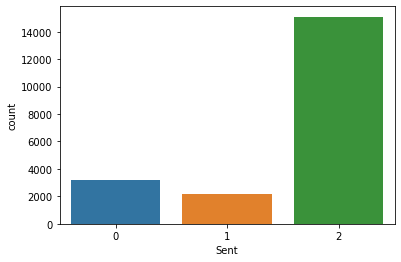

In [ ]:
sns.countplot(data = reviews, x='Sent')

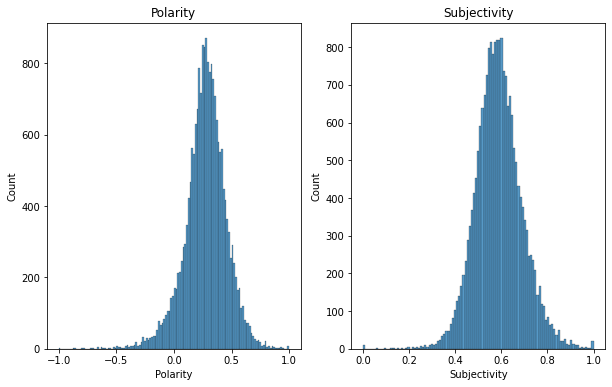

In [ ]:
fig = plt.figure()

fig.set_size_inches(10,6)
ax1, ax2 = fig.subplots(nrows=1, ncols=2)
sns.histplot(reviews.Polarity, ax=ax1)
ax1.set_title('Polarity')
sns.histplot(reviews.Subjectivity, ax=ax2)
ax2.set_title('Subjectivity')

plt.show()

In [ ]:
reviews.Sent.value_counts(normalize=True)

2    0.736567
0    0.156849
1    0.106583
Name: Sent, dtype: float64

---
### Prepare training set

In [ ]:
import numpy as np

seq_len = 512
num_samples = len(reviews)

Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

Xids.shape

(20491, 512)

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 3.7MB/s 
     |████████████████████████████████| 901kB 27.9MB/s 
     |████████████████████████████████| 3.3MB 27.0MB/s 


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

for i, review in enumerate(reviews['Review']):
    tokens = tokenizer.encode_plus(review, max_length = seq_len, truncation=True, 
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

In [ ]:
Xids

array([[  101.,  3505.,  3415., ...,     0.,     0.,     0.],
       [  101., 21534.,  1720., ...,     0.,     0.,     0.],
       [  101.,  3505.,  4045., ...,     0.,     0.,     0.],
       ...,
       [  101., 21534.,  1198., ...,     0.,     0.,     0.],
       [  101.,  3415., 14284., ...,  2927., 18389.,   102.],
       [  101.,  1234.,  2520., ...,     0.,     0.,     0.]])

In [ ]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
arr = reviews['Sent'].values
arr

array([2, 0, 1, ..., 0, 0, 0])

In [ ]:
labels = np.zeros((num_samples, arr.max()+1))

In [ ]:
labels.shape

(20491, 3)

In [ ]:
labels[np.arange(num_samples), arr] = 1

In [ ]:
labels

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

---
### Base model and ML model

In [ ]:
# class weight 시도 -> 성능이 더 안 좋아져서 폐기..

w0 = (1/0.156849)/(1/0.156849 + 1/0.106583 + 1/0.736567)
w1 = (1/0.106583)/(1/0.156849 + 1/0.106583 + 1/0.736567)
w2 = (1/0.736567)/(1/0.156849 + 1/0.106583 + 1/0.736567)

class_weight = {2: 0.3,
                1: 0.5,
                0: 0.2}

In [ ]:
# train/test set 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, log_loss

X_train, X_test, y_train, y_test = train_test_split(Xids, arr, train_size=0.9, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



((18441, 512), (2050, 512), (18441,), (2050,))

In [ ]:
# base model

from scipy import stats
from sklearn.metrics import accuracy_score

major = stats.mode(y_train)[0]
y_pred = [major] * len(y_train)
accuracy_score(y_train, y_pred)

0.7357518572745513

In [ ]:
# randomforestclassifier

rf = RandomForestClassifier(random_state=10, max_depth=10, n_jobs=-1)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
print(log_loss(y_test, rf.predict_proba(X_test), labels=[0,1,2]))

0.7439024390243902
0.7260893326514886


---
### Bert Model

#### dataset prepartaion

In [ ]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (3,)), types: (tf.float64, tf.float64, tf.float64)>

In [ ]:
labels[0,:].shape

(3,)

In [ ]:
def map_func(input_ids, masks, labels):
    return{'input_ids':input_ids, 'attention_mask':masks}, labels

In [ ]:
dataset = dataset.map(map_func)

In [ ]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (3,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [ ]:
batch_size = 32

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [ ]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (32, 512), attention_mask: (32, 512)}, (32, 3)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [ ]:
split = 0.9
size = int((num_samples/batch_size) * split)

In [ ]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

del dataset

In [ ]:
from transformers import TFAutoModel


bert = TFAutoModel.from_pretrained('bert-base-uncased')

bert.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


#### grid search

In [ ]:
%load_ext tensorboard

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([128, 512, 1024]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):

    tf.random.set_seed(42)

    input_ids = tf.keras.layers.Input(shape = (seq_len,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape = (seq_len,), name='attention_mask', dtype='int32')

    embeddings = bert.bert(input_ids, attention_mask=mask)[1]

    x = tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu')(embeddings)
    x = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(x)
    y = tf.keras.layers.Dense(arr.max()+1, activation='softmax', name='outputs')(x)

    model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

    model.layers[2].trainable = False
    model.summary()

    optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_ds,epochs=1,  validation_data=val_ds)
    loss, accuracy = model.evaluate(val_ds)

    return loss, accuracy

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, [loss, accuracy], step=1)

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    hparams = {
        HP_NUM_UNITS: num_units,
        HP_DROPOUT: dropout_rate,
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    loss, accuracy = train_test_model(hparams)
    session_num += 1

#### modeling and evaluating

In [ ]:
from tensorflow.keras import regularizers

tf.random.set_seed(42)

input_ids = tf.keras.layers.Input(shape = (seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape = (seq_len,), name='attention_mask', dtype='int32')

embeddings = bert.bert(input_ids, attention_mask=mask)[1]

x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(arr.max()+1, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False
model.summary()

optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1024)         787456      bert[2][1]                 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
import keras

# 학습시킨 데이터를 저장시키기 위한 코드입니다. 
checkpoint_filepath = "FMbest.hdf5"

# overfitting을 방지하기 위해서 학습 중 early stop을 수행하기 위한 코드입니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기 위한 코드입니다.
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds, 
    epochs=50,
    callbacks=[early_stop, save_best]
)

Epoch 1/50
576/576 [==============================] - 537s 828ms/step - loss: 0.7591 - accuracy: 0.7365 - val_loss: 0.7279 - val_accuracy: 0.7441

Epoch 00001: val_loss improved from inf to 0.72791, saving model to FMbest.hdf5
Epoch 2/50
576/576 [==============================] - 475s 825ms/step - loss: 0.7524 - accuracy: 0.7358 - val_loss: 0.7241 - val_accuracy: 0.7461

Epoch 00002: val_loss improved from 0.72791 to 0.72406, saving model to FMbest.hdf5
Epoch 3/50
576/576 [==============================] - 475s 825ms/step - loss: 0.7497 - accuracy: 0.7342 - val_loss: 0.7498 - val_accuracy: 0.7378

Epoch 00003: val_loss did not improve from 0.72406
Epoch 4/50
576/576 [==============================] - 475s 825ms/step - loss: 0.7452 - accuracy: 0.7352 - val_loss: 0.7386 - val_accuracy: 0.7358

Epoch 00004: val_loss did not improve from 0.72406
Epoch 5/50
576/576 [==============================] - 475s 825ms/step - loss: 0.7439 - accuracy: 0.7356 - val_loss: 0.7044 - val_accuracy: 0.7515


In [ ]:
model.load_weights(checkpoint_filepath)
model.save('sentiment_model')
model.evaluate(val_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: sentiment_model/assets


INFO:tensorflow:Assets written to: sentiment_model/assets


64/64 [==============================] - 42s 648ms/step - loss: 0.7033 - accuracy: 0.7544


[0.703255295753479, 0.75439453125]

In [ ]:
rs_model = tf.keras.models.load_model('sentiment_model')